
# Xarray / MetPy / Machine Learning Tutorial

[xarray](https://docs.xarray.dev/en/stable/) is a powerful Python package that provides
N-dimensional labeled arrays and datasets following the Common Data Model. MetPy's suite of
meteorological calculations are designed to integrate with xarray DataArrays as one of its two
primary data models (the other being Pint Quantities). MetPy also provides DataArray and
Dataset *accessors* (collections of methods and properties attached to the ``.metpy`` property)
for coordinate/CRS and unit operations.

Full information on MetPy's accessors is available in the :doc:`appropriate section of the
reference guide </api/generated/metpy.xarray>`, otherwise, continue on in this
tutorial for a demonstration of the three main components of MetPy's integration with xarray
(coordinates/coordinate reference systems, units, and calculations), as well as instructive
examples for both CF-compliant and non-compliant datasets.

First, some general imports...


In [1]:
import numpy as np
import xarray as xr

# Any import of metpy will activate the accessors
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.units import units

import psutil
import sklearn
import platform
from datetime import datetime

# The below code block is borrowed from the metpy / xarray tutorial. It is very much worth your time to check out!

### CF-Compliant Dataset Example

The GFS sample used throughout this tutorial so far has been an example of a CF-compliant
dataset. These kinds of datasets are easiest to work with it MetPy, since most of the
"xarray magic" uses CF metadata. For this kind of dataset, a typical workflow looks like the
following



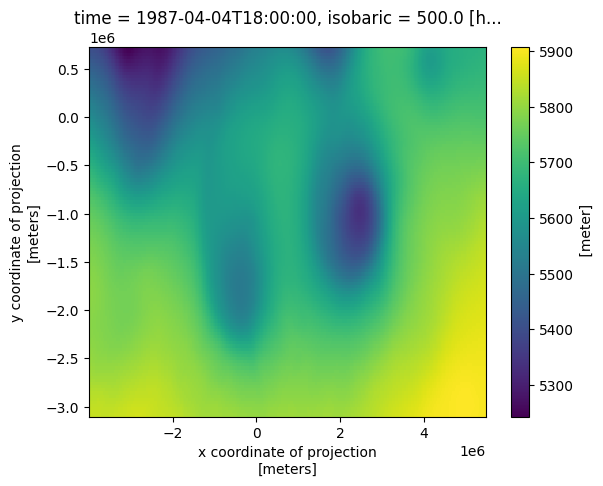

In [2]:
# Load data, parse it for a CF grid mapping, and promote lat/lon data variables to coordinates
data = xr.open_dataset(
    get_test_data('narr_example.nc', False)
).metpy.parse_cf().set_coords(['lat', 'lon'])

# Subset to only the data you need to save on memory usage
subset = data.metpy.sel(isobaric=500 * units.hPa)

# Quantify if you plan on performing xarray operations that need to maintain unit correctness
subset = subset.metpy.quantify()

# Perform calculations
heights = mpcalc.smooth_gaussian(subset['Geopotential_height'], 5)
subset['u_geo'], subset['v_geo'] = mpcalc.geostrophic_wind(heights)

# Plot
heights.plot()

In [3]:
subset

Magnitude,[[[268.49542236328125 268.49542236328125 268.52667236328125 ... 268.69854736328125 268.76104736328125 268.82354736328125] [268.57354736328125 268.57354736328125 268.62042236328125 ... 268.68292236328125 268.72979736328125 268.79229736328125] [268.62042236328125 268.60479736328125 268.63604736328125 ... 268.65167236328125 268.69854736328125 268.76104736328125] ... [247.9485321044922 247.4016571044922 246.8391571044922 ... 258.08917236328125 258.13604736328125 258.18292236328125] [247.6672821044922 247.1047821044922 246.5579071044922 ... 257.99542236328125 258.05792236328125 258.12042236328125] [247.3860321044922 246.8079071044922 246.2766571044922 ... 257.85479736328125 257.91729736328125 257.99542236328125]]]
Units,kelvin
Magnitude,[[[18.8177490234375 18.4427490234375 17.9114990234375 ... -1.3385009765625 -1.1510009765625 -1.4010009765625] [19.3802490234375 20.0208740234375 18.8802490234375 ... -0.7291259765625 -1.0103759765625 -1.0103759765625] [21.0989990234375 20.0052490234375 20.9427490234375 ... -0.2916259765625 -0.5728759765625 -0.8072509765625] ... [25.0677490234375 23.2239990234375 21.4739990234375 ... 6.4896240234375 6.4739990234375 6.2552490234375] [23.5052490234375 21.6771240234375 21.7083740234375 ... 6.3646240234375 6.1927490234375 5.7708740234375] [22.0521240234375 21.8646240234375 20.6927490234375 ... 5.5989990234375 5.5833740234375 5.7552490234375]]]
Units,meter/second
Magnitude,[[[11.17926025390625 10.99176025390625 10.67926025390625 ... -0.07073974609375 -0.22698974609375 -0.36761474609375] [10.89801025390625 10.61676025390625 10.69488525390625 ... 0.00738525390625 -0.25823974609375 -0.25823974609375] [10.33551025390625 10.61676025390625 10.27301025390625 ... 0.19488525390625 -0.16448974609375 -0.36761474609375] ... [7.24176025390625 7.33551025390625 6.69488525390625 ... -5.77386474609375 -5.78948974609375 -5.52386474609375] [7.81988525390625 7.28863525390625 7.21051025390625 ... -5.47698974609375 -5.36761474609375 -4.60198974609375] [8.21051025390625 7.75738525390625 7.58551025390625 ... -4.53948974609375 -4.36761474609375 -4.61761474609375]]]
Units,meter/second
Magnitude,[[[5849.85546875 5849.85546875 5849.85546875 ... 5900.35546875 5899.35546875 5898.85546875] [5848.35546875 5848.35546875 5848.35546875 ... 5900.35546875 5899.85546875 5899.35546875] [5845.85546875 5845.85546875 5845.85546875 ... 5900.85546875 5899.85546875 5899.35546875] ... [5416.85546875 5413.85546875 5411.35546875 ... 5669.35546875 5670.35546875 5671.35546875] [5408.85546875 5405.85546875 5403.85546875 ... 5667.85546875 5668.35546875 5668.85546875] [5400.35546875 5398.35546875 5396.35546875 ... 5666.35546875 5666.85546875 5667.35546875]]]
Units,meter
Magnitude,[[[0.0017160000279545784 0.001706999959424138 0.0016899999463930726 ... 0.00044299999717622995 0.0004360000020824373 0.00042799999937415123] [0.0016850000247359276 0.0016690000193193555 0.0016560000367462635 ... 0.000450999999884516 0.0004419999895617366 0.0004360000020824373] [0.0016629999736323953 0.0016580000519752502 0.00164899998344481 ... 0.00045900000259280205 0.00044899998465552926 0.00043899999582208693] ... [0.0007450000266544521 0.0006960000027902424 0.0006510000093840063 ... 0.00020500000391621143 0.0002099999983329326 0.00020399999630171806] [0.0007200000109151006 0.0006730000022798777 0.0006300000241026282 ... 0.00024500000290572643 0.0002530000056140125 0.00024399999529123306] [0.0006939999875612557 0.0006500000017695129 0.0006099999882280827 ... 0.0003209999995306134 0.00033000000985339284 0.00031900001340545714]]]
Units,dimensionless
Magnitude,[[[8.185479726945138 8.03858589495013 8.725961467809366 ... -2.3806072981793935 -3.119271899424362 -4.006213257718544] [14.90831127411458 15.051786114881441 15.350916859645462 ... -2.5461484894625825 -2.7493066959564505 -2.593518964410889] [18.564840450334387 18.8943676873837 18.676004933394523 ... -1.3667505839729537 -1.762460828671847 -1.2433259099542273] ... [24.425216320032444 23.96335384588123 23.27481494798987

## Let's just work with a data array for this example

In [4]:
temp_da = subset['Temperature']
temp_da

Magnitude,[[[268.49542236328125 268.49542236328125 268.52667236328125 ... 268.69854736328125 268.76104736328125 268.82354736328125] [268.57354736328125 268.57354736328125 268.62042236328125 ... 268.68292236328125 268.72979736328125 268.79229736328125] [268.62042236328125 268.60479736328125 268.63604736328125 ... 268.65167236328125 268.69854736328125 268.76104736328125] ... [247.9485321044922 247.4016571044922 246.8391571044922 ... 258.08917236328125 258.13604736328125 258.18292236328125] [247.6672821044922 247.1047821044922 246.5579071044922 ... 257.99542236328125 258.05792236328125 258.12042236328125] [247.3860321044922 246.8079071044922 246.2766571044922 ... 257.85479736328125 257.91729736328125 257.99542236328125]]]
Units,kelvin


So this has some units and attributes we want to keep

In [5]:
print('shape of da:', temp_da.shape)

shape of da: (1, 118, 292)


### What units does it have?

In [6]:
temp_da.metpy.units

<Unit('kelvin')>

Let's dig into the attributes

In [7]:
temp_da.attrs

{'long_name': 'Temperature @ isobaric',
 'grid_mapping': 'Lambert_Conformal',
 'GRIB_param_name': 'Temperature',
 'GRIB_param_short_name': 'TMP',
 'GRIB_center_id': 7,
 'GRIB_table_id': 131,
 'GRIB_param_number': 11,
 'GRIB_param_id': array([  1,   7, 131,  11], dtype=int32),
 'GRIB_product_definition_type': 'Initialized analysis product',
 'GRIB_level_type': 100,
 'GRIB_VectorComponentFlag': 'gridRelative'}

## Doing 'Machine Learning'

I am just going to add random numbers to a numpy array. This may or may not be a joke about ML, but should be enough to strip out all of the info from the array. 

In [8]:
temp_array = temp_da.values + np.random.uniform(-10, 10, size=(1, 118, 292))
print('temp array type:', type(temp_array))
temp_array

temp array type: <class 'numpy.ndarray'>


array([[[268.95701551, 268.28199814, 262.38957146, ..., 259.53755591,
         276.18537226, 260.00807154],
        [261.49360616, 278.44665661, 272.94629152, ..., 270.65255683,
         264.82363706, 274.16676675],
        [259.74249042, 269.26263628, 276.18996869, ..., 271.10007999,
         265.3837151 , 263.93260989],
        ...,
        [247.74726009, 251.90107732, 241.86797268, ..., 263.52287958,
         252.03417405, 260.5267984 ],
        [241.6588753 , 243.72805443, 245.64079653, ..., 261.75380515,
         259.61303384, 259.60868807],
        [246.19745487, 248.13807494, 249.14645224, ..., 262.00951926,
         254.22763825, 265.13767256]]])

#### Discussion break, does any Deep Learning ML modeling package accept anything but tensors/arrays? 

The [full_like](https://docs.xarray.dev/en/latest/generated/xarray.full_like.html) function in xarray is a useful utility for creating a new DataArray or Dataset with the same shape and coordinates as an existing one, but filled with a specified constant value. It's particularly handy when you need to create a new array that matches the structure of an existing one, such as when initializing data or creating masks. 

Key features:
- Takes an original xarray object as a template
- Fills the new object with a specified value
- Preserves the original's dimensions, coordinates, and attributes

This function makes it easy to create consistent data structures in your xarray workflows.

In [9]:
new_data = xr.full_like(temp_da, 0 )
new_data

<xarray.DataArray 'Temperature' (time: 1, y: 118, x: 292)> Size: 138kB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 8B 1987-04-04T18:00:00
    isobaric   float64 8B 500.0
  * y          (y) float64 944B -3.087e+06 -3.054e+06 ... 6.789e+05 7.114e+05
  * x          (x) float64 2kB -3.977e+06 -3.945e+06 ... 5.437e+06 5.47e+06
    metpy_crs  object 8B Projection: lambert_conformal_conic
    lat        (y, x) float64 276kB 16.07 16.18 16.28 16.39 ... 34.22 34.0 33.79
    lon        (y, x) float64 276kB -140.0 -139.7 -139.5 ... -42.28 -42.07
Attributes:
    long_name:                     Temperature @ isobaric
    grid_mapping:                  Lambert_Conformal
    GRIB_param_name:               Temperature
    GRIB_param_short_name:         TMP
    GRIB_center_id:                7
    GRIB_table_id:                 131
    GRIB_param_number:             11
    GRIB_param_id:                 [  1   7 131  11]
    GRIB_product_definition_type:  Initialized analysis product
    GRIB_level_type:               100
    GRIB_VectorComponentFlag:      gridRelative

In [10]:
new_data.attrs

{'long_name': 'Temperature @ isobaric',
 'grid_mapping': 'Lambert_Conformal',
 'GRIB_param_name': 'Temperature',
 'GRIB_param_short_name': 'TMP',
 'GRIB_center_id': 7,
 'GRIB_table_id': 131,
 'GRIB_param_number': 11,
 'GRIB_param_id': array([  1,   7, 131,  11], dtype=int32),
 'GRIB_product_definition_type': 'Initialized analysis product',
 'GRIB_level_type': 100,
 'GRIB_VectorComponentFlag': 'gridRelative'}

We can add additional attributes

In [11]:
new_data.attrs['Is this a ML output'] = 'yes' # you can update the attributes with whatever you want
new_data.attrs

{'long_name': 'Temperature @ isobaric',
 'grid_mapping': 'Lambert_Conformal',
 'GRIB_param_name': 'Temperature',
 'GRIB_param_short_name': 'TMP',
 'GRIB_center_id': 7,
 'GRIB_table_id': 131,
 'GRIB_param_number': 11,
 'GRIB_param_id': array([  1,   7, 131,  11], dtype=int32),
 'GRIB_product_definition_type': 'Initialized analysis product',
 'GRIB_level_type': 100,
 'GRIB_VectorComponentFlag': 'gridRelative',
 'Is this a ML output': 'yes'}

Do we have units?

In [12]:
new_data.metpy.units

<Unit('dimensionless')>

We can add the units back, without having to sepcify which unit

In [13]:
new_data.values = temp_array * units[str(temp_da.metpy.units)]

In [14]:
new_data

Magnitude,[[[268.9570155057561 268.281998143733 262.3895714625197 ... 259.53755591361556 276.18537225792545 260.008071544057] [261.49360616269706 278.4466566067881 272.94629151570666 ... 270.65255683062554 264.8236370580299 274.1667667529506] [259.74249042341125 269.26263628370293 276.1899686902996 ... 271.10007998728287 265.3837150999591 263.9326098907611] ... [247.7472600859432 251.9010773179074 241.8679726819848 ... 263.52287958327986 252.0341740517612 260.52679840258253] [241.65887529896983 243.72805442601052 245.64079653239608 ... 261.7538051540035 259.61303384307 259.6086880697113] [246.19745486989905 248.13807494182672 249.14645223649757 ... 262.00951926399875 254.2276382506495 265.13767256096327]]]
Units,kelvin


In [15]:
print('what are the units?', new_data.metpy.units)
type(new_data)

what are the units? kelvin


xarray.core.dataarray.DataArray

## If we want to add this DataArray to the original dataset 

In [16]:
# Add to dataset manually
subset["ML_pred_temp"] = new_data
subset

Magnitude,[[[268.49542236328125 268.49542236328125 268.52667236328125 ... 268.69854736328125 268.76104736328125 268.82354736328125] [268.57354736328125 268.57354736328125 268.62042236328125 ... 268.68292236328125 268.72979736328125 268.79229736328125] [268.62042236328125 268.60479736328125 268.63604736328125 ... 268.65167236328125 268.69854736328125 268.76104736328125] ... [247.9485321044922 247.4016571044922 246.8391571044922 ... 258.08917236328125 258.13604736328125 258.18292236328125] [247.6672821044922 247.1047821044922 246.5579071044922 ... 257.99542236328125 258.05792236328125 258.12042236328125] [247.3860321044922 246.8079071044922 246.2766571044922 ... 257.85479736328125 257.91729736328125 257.99542236328125]]]
Units,kelvin
Magnitude,[[[18.8177490234375 18.4427490234375 17.9114990234375 ... -1.3385009765625 -1.1510009765625 -1.4010009765625] [19.3802490234375 20.0208740234375 18.8802490234375 ... -0.7291259765625 -1.0103759765625 -1.0103759765625] [21.0989990234375 20.0052490234375 20.9427490234375 ... -0.2916259765625 -0.5728759765625 -0.8072509765625] ... [25.0677490234375 23.2239990234375 21.4739990234375 ... 6.4896240234375 6.4739990234375 6.2552490234375] [23.5052490234375 21.6771240234375 21.7083740234375 ... 6.3646240234375 6.1927490234375 5.7708740234375] [22.0521240234375 21.8646240234375 20.6927490234375 ... 5.5989990234375 5.5833740234375 5.7552490234375]]]
Units,meter/second
Magnitude,[[[11.17926025390625 10.99176025390625 10.67926025390625 ... -0.07073974609375 -0.22698974609375 -0.36761474609375] [10.89801025390625 10.61676025390625 10.69488525390625 ... 0.00738525390625 -0.25823974609375 -0.25823974609375] [10.33551025390625 10.61676025390625 10.27301025390625 ... 0.19488525390625 -0.16448974609375 -0.36761474609375] ... [7.24176025390625 7.33551025390625 6.69488525390625 ... -5.77386474609375 -5.78948974609375 -5.52386474609375] [7.81988525390625 7.28863525390625 7.21051025390625 ... -5.47698974609375 -5.36761474609375 -4.60198974609375] [8.21051025390625 7.75738525390625 7.58551025390625 ... -4.53948974609375 -4.36761474609375 -4.61761474609375]]]
Units,meter/second
Magnitude,[[[5849.85546875 5849.85546875 5849.85546875 ... 5900.35546875 5899.35546875 5898.85546875] [5848.35546875 5848.35546875 5848.35546875 ... 5900.35546875 5899.85546875 5899.35546875] [5845.85546875 5845.85546875 5845.85546875 ... 5900.85546875 5899.85546875 5899.35546875] ... [5416.85546875 5413.85546875 5411.35546875 ... 5669.35546875 5670.35546875 5671.35546875] [5408.85546875 5405.85546875 5403.85546875 ... 5667.85546875 5668.35546875 5668.85546875] [5400.35546875 5398.35546875 5396.35546875 ... 5666.35546875 5666.85546875 5667.35546875]]]
Units,meter
Magnitude,[[[0.0017160000279545784 0.001706999959424138 0.0016899999463930726 ... 0.00044299999717622995 0.0004360000020824373 0.00042799999937415123] [0.0016850000247359276 0.0016690000193193555 0.0016560000367462635 ... 0.000450999999884516 0.0004419999895617366 0.0004360000020824373] [0.0016629999736323953 0.0016580000519752502 0.00164899998344481 ... 0.00045900000259280205 0.00044899998465552926 0.00043899999582208693] ... [0.0007450000266544521 0.0006960000027902424 0.0006510000093840063 ... 0.00020500000391621143 0.0002099999983329326 0.00020399999630171806] [0.0007200000109151006 0.0006730000022798777 0.0006300000241026282 ... 0.00024500000290572643 0.0002530000056140125 0.00024399999529123306] [0.0006939999875612557 0.0006500000017695129 0.0006099999882280827 ... 0.0003209999995306134 0.00033000000985339284 0.00031900001340545714]]]
Units,dimensionless
Magnitude,[[[8.185479726945138 8.03858589495013 8.725961467809366 ... -2.3806072981793935 -3.119271899424362 -4.006213257718544] [14.90831127411458 15.051786114881441 15.350916859645462 ... -2.5461484894625825 -2.7493066959564505 -2.593518964410889] [18.564840450334387 18.8943676873837 18.676004933394523 ... -1.3667505839729537 -1.762460828671847 -1.2433259099542273] ... [24.425216320032444 23.96335384588123 23.27481494798987

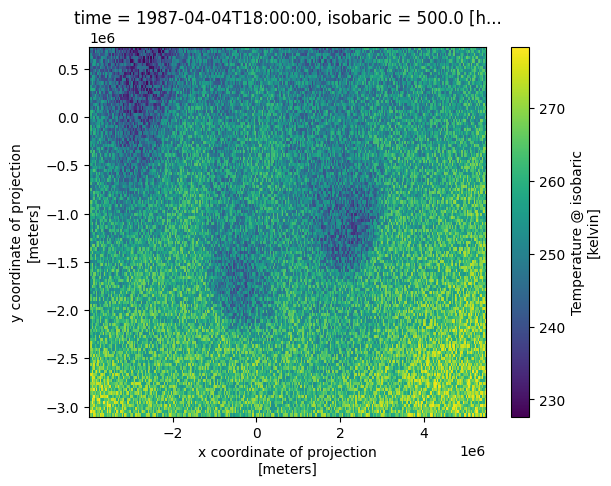

In [17]:
subset.ML_pred_temp.plot()

In [18]:
subset.ML_pred_temp

Magnitude,[[[268.9570155057561 268.281998143733 262.3895714625197 ... 259.53755591361556 276.18537225792545 260.008071544057] [261.49360616269706 278.4466566067881 272.94629151570666 ... 270.65255683062554 264.8236370580299 274.1667667529506] [259.74249042341125 269.26263628370293 276.1899686902996 ... 271.10007998728287 265.3837150999591 263.9326098907611] ... [247.7472600859432 251.9010773179074 241.8679726819848 ... 263.52287958327986 252.0341740517612 260.52679840258253] [241.65887529896983 243.72805442601052 245.64079653239608 ... 261.7538051540035 259.61303384307 259.6086880697113] [246.19745486989905 248.13807494182672 249.14645223649757 ... 262.00951926399875 254.2276382506495 265.13767256096327]]]
Units,kelvin


## CF for ML

Let's add some additional attributes. What else would you add?

In [19]:
system_info = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'num_cpus': psutil.cpu_count(),
    'ram_gb': f"{psutil.virtual_memory().total / (1024 ** 3):.2f}",
    'sklearn_version': sklearn.__version__,
    'numpy_version': np.__version__
}

print(system_info)

{'timestamp': '2024-08-27 19:27:43', 'num_cpus': 12, 'ram_gb': '32.00', 'sklearn_version': '1.4.1.post1', 'numpy_version': '1.26.4'}


In [20]:
subset.ML_pred_temp.attrs.update(system_info)
subset.ML_pred_temp.attrs

{'long_name': 'Temperature @ isobaric',
 'grid_mapping': 'Lambert_Conformal',
 'GRIB_param_name': 'Temperature',
 'GRIB_param_short_name': 'TMP',
 'GRIB_center_id': 7,
 'GRIB_table_id': 131,
 'GRIB_param_number': 11,
 'GRIB_param_id': array([  1,   7, 131,  11], dtype=int32),
 'GRIB_product_definition_type': 'Initialized analysis product',
 'GRIB_level_type': 100,
 'GRIB_VectorComponentFlag': 'gridRelative',
 'Is this a ML output': 'yes',
 'timestamp': '2024-08-27 19:27:43',
 'num_cpus': 12,
 'ram_gb': '32.00',
 'sklearn_version': '1.4.1.post1',
 'numpy_version': '1.26.4'}